In [1]:
from funcs import *

# Duplicate Question Classifier 
In this notebook, we take a stab at the quora question pair dataset via kaggle. The object is to build a classifier which can detect 'duplicate questions'. As you will see below, some of these questions get <i>very</i> 
similar while meaning entirely different things. Our hypothesis is that by breaking up a question pair by part of speech (ie noun, verb..), we can achieve more accurate results than comparing the questions on whole.

### Data From Kaggle/Quora: https://www.kaggle.com/quora/question-pairs-dataset
### Language Model from SpaCy: https://spacy.io/models/en#en_core_web_lg




In [140]:
raw = pd.read_csv('questions.csv')
nlp = spacy.load('en_core_web_lg')

Ensure the data are loaded correctly:

In [3]:
raw.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


### Inspecting some questions:


In [208]:
def question_pair_gen(df,range_,start=None):
    index = iter(range(range_))
    if start:
        for n in range(start):
            next(index)
    while True:
        next_ind = next(index)
        print(raw['question1'].loc[next_ind])
        print(raw['question2'].loc[next_ind])
        print(raw.is_duplicate.loc[next_ind])
        yield 

In [209]:
qcheck= question_pair_gen(raw,200000,10000)

In [210]:
next(qcheck)

Is it safe for a woman to travel alone in Vietnam?
Is it safe for a woman to travel alone in Japan?
0


In [211]:
next(qcheck)

What do paving stones cost?
What are "paving stones"?
0


### Check and Remove Null Values:

In [4]:
len(raw)-len(raw.dropna())

3

In [5]:
raw.dropna(inplace=True)

In [228]:
first_100k_true = raw[raw.is_duplicate==1][:100_000]
first_100k_false = raw[raw.is_duplicate==0][:100_000]
train = first_100k_false.append(first_100k_true).reset_index(drop=True)


In [115]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [46]:
def prepare(traindf):
    #create iterators of question columns
    q1_docs_ = nlp.pipe(iter(traindf['question1'].str.lower())) #nlp.pipe takes an iterator and returns a generator that preforms spacy pipeline 
    q2_docs_ = nlp.pipe(iter(traindf['question2'].str.lower()))
    return zip(q1_docs_,q2_docs_)
    
def parse(doc_pairs,keep_docs=True,keep_text=False):
    feat_dict = defaultdict(list)
    pos_list = ['noun','verb','adj','adv']

    for q1,q2 in tqdm(doc_pairs):
        if keep_docs:
            feat_dict['q1_docs'].append(q1)
            feat_dict['q2_docs'].append(q2)
        if keep_text:
            feat_dict['q1_txt'].append(q1.text)
            feat_dict['q2_txt'].append(q2.text)


        feat_dict['sim'].append(q1.similarity(q2))
        feat_dict['sim_of_diffs'].append(sim_of_diffs(q1,q2))
        
        for pos in pos_list:
            feat_dict[f'sim_of_{pos}s'].append(sim_by_pos(q1,q2,pos))
            feat_dict[f'sim_of_diffs_{pos}s'].append(sim_of_diffs(q1,q2,pos=pos))
            feat_dict[f'{pos}_mratio'].append(pos_match_ratio(q1,q2,pos))


        feat_dict['propn_mratio'].append(pos_match_ratio(q1,q2,'propn'))
        feat_dict['ent_ratio'].append(ent_match_ratio(q1,q2))
        feat_dict['ent_type_match_ratio'].append(ent_type_match_ratio(q1,q2))

    return pd.DataFrame(data=feat_dict)


In [47]:
prepare(train)

In [48]:
df = parse(prepare(train)) # <====TAKES A WHILE




0it [00:00, ?it/s]

1it [00:04,  4.12s/it]

91it [00:04,  2.89s/it]

182it [00:04,  2.02s/it]

287it [00:04,  1.41s/it]

398it [00:04,  1.01it/s]

503it [00:04,  1.44it/s]

610it [00:04,  2.06it/s]

714it [00:04,  2.94it/s]

812it [00:04,  4.19it/s]

916it [00:05,  5.98it/s]

1015it [00:09,  7.71it/s]

1109it [00:09, 10.98it/s]

1211it [00:09, 15.61it/s]

1312it [00:09, 22.16it/s]

1415it [00:09, 31.37it/s]

1518it [00:09, 44.23it/s]

1625it [00:09, 62.08it/s]

1732it [00:09, 86.51it/s]

1847it [00:09, 119.69it/s]

1958it [00:10, 163.41it/s]

2065it [00:15, 50.67it/s] 

2147it [00:15, 70.52it/s]

2248it [00:15, 97.77it/s]

2356it [00:15, 134.42it/s]

2464it [00:15, 182.10it/s]

2563it [00:16, 240.97it/s]

2663it [00:16, 311.54it/s]

2760it [00:16, 390.65it/s]

2865it [00:16, 480.88it/s]

2970it [00:16, 573.81it/s]

3071it [00:21, 66.13it/s] 

3169it [00:21, 91.80it/s]

3268it [00:21, 126.12it/s]

3372it [00:21, 171.23it/s]

3479it [00:21, 228.90it/s]

3581it [00:21, 298.07it/s]

3684

24431it [02:22, 270.58it/s]

24515it [02:23, 339.20it/s]

24598it [02:23, 411.68it/s]

24681it [02:23, 483.19it/s]

24770it [02:23, 559.62it/s]

24854it [02:23, 617.51it/s]

24946it [02:23, 684.93it/s]

25032it [02:28, 50.18it/s] 

25109it [02:29, 69.70it/s]

25192it [02:29, 96.09it/s]

25281it [02:29, 131.19it/s]

25369it [02:29, 176.14it/s]

25459it [02:29, 232.11it/s]

25558it [02:29, 300.99it/s]

25658it [02:29, 380.46it/s]

25758it [02:29, 466.85it/s]

25858it [02:29, 555.71it/s]

25964it [02:29, 647.40it/s]

26063it [02:34, 63.19it/s] 

26146it [02:34, 87.40it/s]

26235it [02:35, 119.81it/s]

26324it [02:35, 161.72it/s]

26415it [02:35, 214.63it/s]

26508it [02:35, 278.81it/s]

26599it [02:35, 351.62it/s]

26696it [02:35, 434.29it/s]

26790it [02:35, 517.59it/s]

26889it [02:35, 603.38it/s]

26988it [02:35, 683.24it/s]

27083it [02:40, 61.99it/s] 

27162it [02:40, 85.66it/s]

27253it [02:40, 117.63it/s]

27341it [02:40, 158.93it/s]

27433it [02:41, 211.25it/s]

27527it [02:41, 27

45271it [04:32, 147.73it/s]

45339it [04:32, 192.14it/s]

45408it [04:32, 245.04it/s]

45484it [04:32, 307.41it/s]

45563it [04:32, 376.17it/s]

45644it [04:32, 448.14it/s]

45726it [04:32, 517.55it/s]

45808it [04:32, 581.89it/s]

45887it [04:33, 628.20it/s]

45966it [04:33, 662.15it/s]

46044it [04:39, 41.63it/s] 

46121it [04:39, 58.12it/s]

46204it [04:39, 80.60it/s]

46291it [04:39, 110.73it/s]

46381it [04:39, 150.21it/s]

46478it [04:39, 201.18it/s]

46572it [04:39, 263.15it/s]

46664it [04:39, 334.67it/s]

46761it [04:39, 416.26it/s]

46861it [04:40, 504.05it/s]

46963it [04:40, 594.19it/s]

47059it [04:45, 59.82it/s] 

47127it [04:45, 82.29it/s]

47209it [04:45, 112.69it/s]

47292it [04:45, 151.99it/s]

47383it [04:45, 202.59it/s]

47471it [04:45, 263.42it/s]

47560it [04:45, 333.54it/s]

47652it [04:45, 412.38it/s]

47752it [04:45, 500.55it/s]

47849it [04:46, 585.39it/s]

47952it [04:46, 671.02it/s]

48048it [04:51, 57.13it/s] 

48122it [04:51, 78.99it/s]

48204it [04:51, 10

66118it [06:41, 81.22it/s]

66198it [06:41, 111.15it/s]

66290it [06:41, 150.91it/s]

66383it [06:41, 201.56it/s]

66477it [06:41, 263.59it/s]

66563it [06:41, 330.80it/s]

66648it [06:41, 391.38it/s]

66728it [06:41, 461.50it/s]

66812it [06:41, 532.72it/s]

66894it [06:42, 594.65it/s]

66975it [06:42, 633.81it/s]

67055it [06:48, 41.25it/s] 

67129it [06:48, 57.54it/s]

67210it [06:48, 79.72it/s]

67290it [06:48, 109.17it/s]

67382it [06:48, 148.37it/s]

67477it [06:48, 198.65it/s]

67566it [06:48, 258.96it/s]

67663it [06:49, 331.83it/s]

67751it [06:49, 407.85it/s]

67846it [06:49, 491.77it/s]

67949it [06:49, 583.00it/s]

68043it [06:54, 57.92it/s] 

68112it [06:54, 79.84it/s]

68188it [06:54, 109.12it/s]

68266it [06:54, 147.00it/s]

68347it [06:54, 194.81it/s]

68433it [06:54, 253.63it/s]

68521it [06:54, 322.45it/s]

68611it [06:55, 398.85it/s]

68705it [06:55, 481.10it/s]

68792it [06:55, 555.45it/s]

68884it [06:55, 629.70it/s]

68972it [06:55, 681.86it/s]

69059it [07:00, 54

86663it [08:46, 390.49it/s]

86757it [08:46, 473.30it/s]

86852it [08:46, 557.02it/s]

86943it [08:46, 628.60it/s]

87034it [08:52, 50.72it/s] 

87098it [08:52, 69.26it/s]

87157it [08:52, 94.19it/s]

87220it [08:52, 126.39it/s]

87288it [08:52, 166.87it/s]

87359it [08:52, 216.23it/s]

87434it [08:53, 274.42it/s]

87502it [08:53, 331.75it/s]

87569it [08:53, 390.17it/s]

87638it [08:53, 448.19it/s]

87709it [08:53, 503.00it/s]

87778it [08:53, 536.05it/s]

87845it [08:53, 561.88it/s]

87919it [08:53, 605.59it/s]

87994it [08:53, 642.64it/s]

88065it [08:59, 39.68it/s] 

88144it [08:59, 55.47it/s]

88230it [08:59, 77.08it/s]

88317it [08:59, 106.08it/s]

88403it [09:00, 143.88it/s]

88497it [09:00, 192.84it/s]

88589it [09:00, 252.70it/s]

88688it [09:00, 325.26it/s]

88781it [09:00, 403.49it/s]

88880it [09:00, 490.51it/s]

88976it [09:00, 574.68it/s]

89070it [09:05, 55.94it/s] 

89145it [09:05, 77.44it/s]

89228it [09:06, 106.36it/s]

89312it [09:06, 144.07it/s]

89397it [09:06, 191

108153it [10:54, 106.95it/s]

108252it [10:54, 146.02it/s]

108355it [10:54, 196.48it/s]

108460it [10:54, 259.85it/s]

108564it [10:54, 335.28it/s]

108672it [10:54, 422.71it/s]

108777it [10:54, 514.87it/s]

108891it [10:54, 615.15it/s]

109001it [10:59, 78.53it/s] 

109085it [10:59, 107.86it/s]

109180it [10:59, 146.89it/s]

109279it [10:59, 197.29it/s]

109381it [10:59, 260.26it/s]

109482it [10:59, 334.58it/s]

109586it [10:59, 419.74it/s]

109685it [10:59, 507.14it/s]

109786it [11:00, 595.07it/s]

109897it [11:00, 690.32it/s]

110001it [11:05, 57.90it/s] 

110073it [11:05, 79.89it/s]

110153it [11:05, 109.42it/s]

110251it [11:06, 149.13it/s]

110347it [11:06, 199.66it/s]

110442it [11:06, 261.54it/s]

110546it [11:06, 337.23it/s]

110644it [11:06, 419.53it/s]

110742it [11:06, 506.38it/s]

110847it [11:06, 599.16it/s]

110952it [11:06, 687.39it/s]

111053it [11:11, 72.80it/s] 

111147it [11:11, 100.65it/s]

111244it [11:11, 137.62it/s]

111340it [11:11, 185.22it/s]

111444it [1

131371it [12:55, 254.44it/s]

131472it [12:55, 327.97it/s]

131577it [12:55, 413.14it/s]

131674it [12:55, 497.87it/s]

131777it [12:56, 588.65it/s]

131884it [12:56, 680.03it/s]

131988it [12:56, 758.50it/s]

132090it [13:00, 73.80it/s] 

132178it [13:00, 101.74it/s]

132279it [13:00, 139.28it/s]

132380it [13:00, 187.80it/s]

132481it [13:00, 248.47it/s]

132583it [13:01, 321.30it/s]

132692it [13:01, 407.41it/s]

132801it [13:01, 501.42it/s]

132909it [13:01, 596.68it/s]

133013it [13:05, 73.88it/s] 

133104it [13:05, 101.97it/s]

133192it [13:05, 138.73it/s]

133295it [13:05, 187.35it/s]

133398it [13:06, 248.17it/s]

133500it [13:06, 320.92it/s]

133601it [13:06, 402.71it/s]

133704it [13:06, 491.94it/s]

133808it [13:06, 583.69it/s]

133909it [13:06, 667.44it/s]

134009it [13:10, 70.52it/s] 

134093it [13:11, 97.23it/s]

134187it [13:11, 132.99it/s]

134288it [13:11, 179.68it/s]

134391it [13:11, 238.75it/s]

134492it [13:11, 309.58it/s]

134589it [13:11, 387.85it/s]

134684it [1

154518it [15:02, 322.74it/s]

154627it [15:02, 408.85it/s]

154732it [15:02, 499.97it/s]

154844it [15:02, 598.98it/s]

154958it [15:02, 696.98it/s]

155065it [15:07, 76.07it/s] 

155154it [15:07, 104.80it/s]

155251it [15:07, 143.07it/s]

155351it [15:07, 192.48it/s]

155457it [15:07, 255.11it/s]

155555it [15:07, 327.63it/s]

155660it [15:07, 412.67it/s]

155770it [15:07, 507.40it/s]

155876it [15:07, 600.88it/s]

155987it [15:08, 696.68it/s]

156093it [15:12, 75.70it/s] 

156181it [15:12, 104.28it/s]

156288it [15:12, 142.97it/s]

156396it [15:12, 193.23it/s]

156500it [15:12, 255.53it/s]

156607it [15:12, 331.07it/s]

156711it [15:12, 415.85it/s]

156817it [15:13, 507.79it/s]

156928it [15:13, 606.01it/s]

157033it [15:17, 72.13it/s] 

157115it [15:17, 99.28it/s]

157210it [15:17, 135.67it/s]

157314it [15:17, 183.52it/s]

157419it [15:18, 243.75it/s]

157523it [15:18, 316.33it/s]

157631it [15:18, 401.24it/s]

157734it [15:18, 490.93it/s]

157841it [15:18, 585.93it/s]

157949it [1

177859it [17:04, 605.72it/s]

177964it [17:04, 693.11it/s]

178069it [17:08, 73.68it/s] 

178155it [17:08, 101.51it/s]

178252it [17:08, 138.75it/s]

178348it [17:08, 186.60it/s]

178447it [17:09, 246.63it/s]

178551it [17:09, 319.64it/s]

178655it [17:09, 403.14it/s]

178764it [17:09, 496.85it/s]

178874it [17:09, 594.31it/s]

178987it [17:09, 692.84it/s]

179094it [17:13, 75.39it/s] 

179183it [17:13, 103.91it/s]

179282it [17:14, 142.01it/s]

179379it [17:14, 190.80it/s]

179477it [17:14, 251.43it/s]

179577it [17:14, 324.25it/s]

179680it [17:14, 408.13it/s]

179788it [17:14, 501.69it/s]

179899it [17:14, 600.16it/s]

180003it [17:19, 73.26it/s] 

180090it [17:19, 101.00it/s]

180186it [17:19, 138.04it/s]

180285it [17:19, 186.00it/s]

180389it [17:19, 246.62it/s]

180494it [17:19, 320.06it/s]

180598it [17:19, 403.95it/s]

180705it [17:19, 496.45it/s]

180814it [17:19, 593.10it/s]

180922it [17:19, 685.68it/s]

181027it [17:24, 75.78it/s] 

181115it [17:24, 104.37it/s]

181212it [

In [50]:
labeled_df = pd.concat([y,df],axis=1)

In [229]:
X=labeled_df.iloc[:,3:]
y = train.is_duplicate #We'll grab this from earlier...

In [52]:
X.to_pickle('X.pickle')
y.to_pickle('y.pickle')

In [53]:
from funcs import feature_sampler

In [212]:
df.head()

,q1_docs,q2_docs,sim,sim_of_diffs,sim_of_nouns,sim_of_diffs_nouns,noun_mratio,sim_of_verbs,sim_of_diffs_verbs,verb_mratio,sim_of_adjs,sim_of_diffs_adjs,adj_mratio,sim_of_advs,sim_of_diffs_advs,adv_mratio,propn_mratio,ent_ratio,ent_type_match_ratio
0,"(what, is, the, step, by, step, guide, to, inv...","(what, is, the, step, by, step, guide, to, inv...",0.986684,0.000000,0.966658,0.000000,0.92,1.000000,0.000000,1.00,0.0,0.0,1.0,0.000000,0.000000,1.00,1.00,0.0,0.0
1,"(what, is, the, story, of, kohinoor, (, koh, -...","(what, would, happen, if, the, indian, governm...",0.924999,0.633827,0.825731,0.084865,0.71,0.501388,0.501388,0.23,0.0,0.0,0.0,0.000000,0.000000,0.00,0.69,1.0,1.0
2,"(how, can, i, increase, the, speed, of, my, in...","(how, can, internet, speed, be, increased, by,...",0.929068,0.745956,0.773221,0.576183,0.43,0.811352,0.480675,0.66,0.0,0.0,0.0,1.000000,0.000000,1.00,1.00,1.0,1.0
3,"(why, am, i, mentally, very, lonely, ?, how, c...","(find, the, remainder, when, [, math]23^{24}[/...",0.730742,0.635728,0.000000,0.000000,0.00,0.648142,0.598780,0.46,0.0,0.0,0.0,0.733251,0.733251,0.38,0.00,1.0,1.0
4,"(which, one, dissolve, in, water, quikly, suga...","(which, fish, would, survive, in, salt, water, ?)",0.846616,0.530964,0.786658,0.357563,0.44,0.323007,0.323007,0.46,1.0,0.0,1.0,0.000000,0.000000,0.00,1.00,0.0,0.0


In [213]:
def feature_sampler(index,df=None,y=None):
    test1,test2 = (df.q1_docs.loc[index],df.q2_docs.loc[index])
    pos_list = ['noun','verb','adj','adv']
    print('question 1: ',test1)
    print('question 2: ',test2)
    print('is duplicate: ',y.loc[index])
    print('\n')
    print('similarities: ', test1.similarity(test2))
    print('similarity of differences: ',sim_of_diffs(test1,test2))

    for pos in pos_list:

        print('\n _______%ss_______'%pos)
        print(get_pos_tags(test1,test2,pos))
        print('%s_matchratio: '%pos,pos_match_ratio(test1,test2,pos))
        print('sim: ',sim_by_pos(test1,test2,pos))
        print('s.o.d.s: ',sim_of_diffs(test1,test2,pos=pos))

    print('\n _______Proper_Nouns_______')
    print(get_pos_tags(test1,test2,'propn'))
   # print('has_propns: ',both_have_pos((test1,test2),'propn'))
    print('propn_matchratio:',pos_match_ratio(test1,test2,'propn'))
    print('sim: ',sim_by_pos(test1,test2,'propn'))
    print('s.o.d.s: ',sim_of_diffs(test1,test2,pos='propn'))

    print('\n _______Entities_______')
    print(get_ents((test1,test2)))
    print('ent_matchratio: ',ent_match_ratio(test1,test2))
    #print('has_ents: ',both_have_ents((test1,test2)))


    print('\n _______Entity_Types_______')
    print(get_ent_types((test1,test2)))
    print('ent_type_match ratio: ',ent_type_match_ratio(test1,test2))


In [232]:
feature_sampler(100005,df=labeled_df,y=y)

question 1:  what would a trump presidency mean for current international master’s students on an f1 visa?
question 2:  how will a trump presidency affect the students presently in us or planning to study in us?
is duplicate:  1


similarities:  0.9105124676016237
similarity of differences:  0.844497

 _______nouns_______
([what, trump, presidency, master, students, visa], [trump, presidency, students])
noun_matchratio:  0.74
sim:  0.8555947
s.o.d.s:  0

 _______verbs_______
([would, mean], [will, affect, planning, study])
verb_matchratio:  0.41000000000000003
sim:  0.6680611
s.o.d.s:  0.6680611

 _______adjs_______
([current, international, f1], [])
adj_matchratio:  0.0
sim:  0
s.o.d.s:  0

 _______advs_______
([], [how, presently])
adv_matchratio:  0.0
sim:  0
s.o.d.s:  0

 _______Proper_Nouns_______
([], [])
propn_matchratio: 1.0
sim:  0
s.o.d.s:  0

 _______Entities_______
([], [])
ent_matchratio:  1.0

 _______Entity_Types_______
([], [])
ent_type_match ratio:  1.0


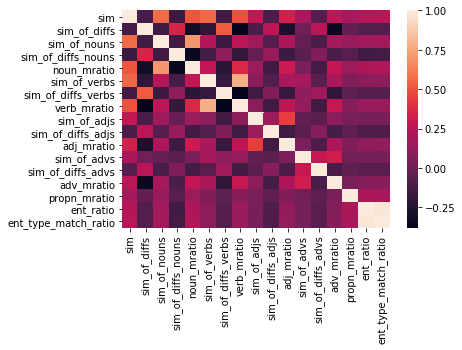

In [233]:
sns.heatmap(X.corr())

In [404]:
labeled_df.head()

,is_duplicate,q1_docs,q2_docs,sim,sim_of_diffs,sim_of_nouns,sim_of_diffs_nouns,noun_mratio,sim_of_verbs,sim_of_diffs_verbs,verb_mratio,sim_of_adjs,sim_of_diffs_adjs,adj_mratio,sim_of_advs,sim_of_diffs_advs,adv_mratio,propn_mratio,ent_ratio,ent_type_match_ratio
0,0,"(what, is, the, step, by, step, guide, to, inv...","(what, is, the, step, by, step, guide, to, inv...",0.986684,0.000000,0.966658,0.000000,0.92,1.000000,0.000000,1.00,0.0,0.0,1.0,0.000000,0.000000,1.00,1.00,0.0,0.0
1,0,"(what, is, the, story, of, kohinoor, (, koh, -...","(what, would, happen, if, the, indian, governm...",0.924999,0.633827,0.825731,0.084865,0.71,0.501388,0.501388,0.23,0.0,0.0,0.0,0.000000,0.000000,0.00,0.69,1.0,1.0
2,0,"(how, can, i, increase, the, speed, of, my, in...","(how, can, internet, speed, be, increased, by,...",0.929068,0.745956,0.773221,0.576183,0.43,0.811352,0.480675,0.66,0.0,0.0,0.0,1.000000,0.000000,1.00,1.00,1.0,1.0
3,0,"(why, am, i, mentally, very, lonely, ?, how, c...","(find, the, remainder, when, [, math]23^{24}[/...",0.730742,0.635728,0.000000,0.000000,0.00,0.648142,0.598780,0.46,0.0,0.0,0.0,0.733251,0.733251,0.38,0.00,1.0,1.0
4,0,"(which, one, dissolve, in, water, quikly, suga...","(which, fish, would, survive, in, salt, water, ?)",0.846616,0.530964,0.786658,0.357563,0.44,0.323007,0.323007,0.46,1.0,0.0,1.0,0.000000,0.000000,0.00,1.00,0.0,0.0


/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


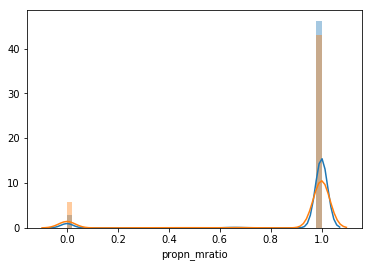

In [234]:

plt.subplot()
sns.distplot(X.loc[len(X)/2:].propn_mratio)
sns.distplot(X.loc[:len(X)/2].propn_mratio)

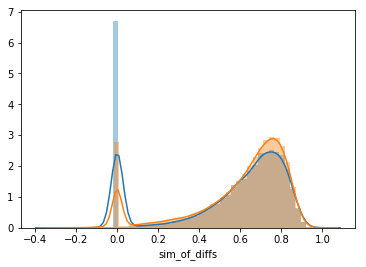

In [235]:
sns.distplot(X.loc[len(X)/2:].sim_of_diffs)
sns.distplot(X.loc[:len(X)/2].sim_of_diffs)

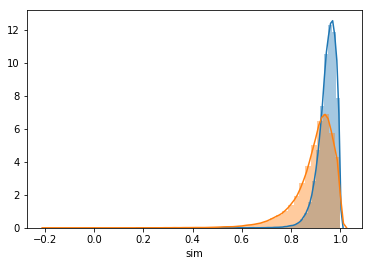

In [236]:
sns.distplot(X.loc[len(X)/2:].sim)
sns.distplot(X.loc[:len(X)/2].sim)

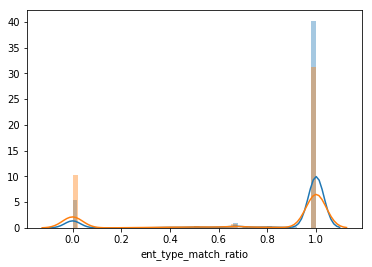

In [237]:
sns.distplot(X.loc[len(X)/2:].ent_type_match_ratio)
sns.distplot(X.loc[:len(X)/2].ent_type_match_ratio)

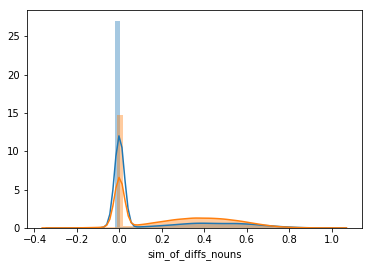

In [238]:
sns.distplot(X.loc[len(X)/2:].sim_of_diffs_nouns)
sns.distplot(X.loc[:len(X)/2].sim_of_diffs_nouns)

In [239]:
X_only_pos.head()

,sim_of_nouns,sim_of_diffs_nouns,noun_mratio,sim_of_verbs,sim_of_diffs_verbs,verb_mratio,sim_of_adjs,sim_of_diffs_adjs,adj_mratio,sim_of_advs,sim_of_diffs_advs,adv_mratio,propn_mratio,ent_ratio,ent_type_match_ratio
0,0.966658,0.000000,0.92,1.000000,0.000000,1.00,0.0,0.0,1.0,0.000000,0.000000,1.00,1.00,0.0,0.0
1,0.825731,0.084865,0.71,0.501388,0.501388,0.23,0.0,0.0,0.0,0.000000,0.000000,0.00,0.69,1.0,1.0
2,0.773221,0.576183,0.43,0.811352,0.480675,0.66,0.0,0.0,0.0,1.000000,0.000000,1.00,1.00,1.0,1.0
3,0.000000,0.000000,0.00,0.648142,0.598780,0.46,0.0,0.0,0.0,0.733251,0.733251,0.38,0.00,1.0,1.0
4,0.786658,0.357563,0.44,0.323007,0.323007,0.46,1.0,0.0,1.0,0.000000,0.000000,0.00,1.00,0.0,0.0


In [240]:
X_no_pos = X[['sim','sim_of_diffs']]
X_only_pos = X.iloc[:,2:]

In [353]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_npos_train,X_npos_test,yn_train,yn_test = train_test_split(X_no_pos,y)
X_opos_train,X_opos_test,yo_train,yo_test = train_test_split(X_only_pos,y)

## Fitting with Only Parts of Speech 

In [359]:
logreg = LogisticRegression(fit_intercept = False, C = .1,tol=.000001)
logreg.fit(X_opos_train, yo_train)

y_hat_train = logreg.predict(X_opos_train)
y_hat_test = logreg.predict(X_opos_test)


residuals = yo_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))
print(confusion_matrix(yo_test, y_hat_test))

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    0.65274
-1    0.20092
 1    0.14634
Name: is_duplicate, dtype: float64
[[14995 10046]
 [ 7317 17642]]


## Fitting with Only Doc Sim + S.o.D

In [363]:

logreg = LogisticRegression(fit_intercept = True,C = 1,tol=.01,)
logreg.fit(X_npos_train, yn_train)

y_hat_train = logreg.predict(X_npos_train)
y_hat_test = logreg.predict(X_npos_test)


residuals = yn_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))

print(logreg.score(X_npos_test,yn_test))
print(confusion_matrix(yn_test, y_hat_test))

 0    0.67428
-1    0.20028
 1    0.12544
Name: is_duplicate, dtype: float64
0.67428
[[14829 10014]
 [ 6272 18885]]


/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Fitting w/All Features

In [365]:

logreg = LogisticRegression(fit_intercept = None, C = .1, tol=.01, penalty='l2')
logreg.fit(X_train, y_train)

y_hat_train = logreg.predict(X_train)
y_hat_test = logreg.predict(X_test)


residuals = y_test - y_hat_test
print(pd.Series(residuals).value_counts(normalize=True))

print(logreg.score(X_test,y_test))
print(confusion_matrix(y_test, y_hat_test))

/Users/colemiller1/anaconda3/envs/learn-env/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


 0    0.6638
-1    0.1873
 1    0.1489
Name: is_duplicate, dtype: float64
0.6638
[[15518  9365]
 [ 7445 17672]]


In [382]:
from sklearn import linear_model
sgdclf = linear_model.SGDClassifier(loss='hinge',max_iter=10000, tol=1e-3,alpha=.0001,
                                    penalty='elasticnet',l1_ratio=.8)
sgdclf.fit(X_train, y_train)

y_hat_train = sgdclf.predict(X_train)
y_hat_test = sgdclf.predict(X_test)


#y_test_array = np.array(y_test['is_duplicate'])
residuals = y_test - y_hat_test
pd.Series(residuals).value_counts()
pd.Series(residuals).value_counts(normalize=True)
print(confusion_matrix(y_test, y_hat_test))


[[15336  9547]
 [ 5795 19322]]


In [383]:
sgdclf.score(X_test,y_test)

0.69316

Mean Cross Validation Score for Random Forest Classifier: 74.05%


In [393]:
def plot_feature_importances(model,X):
    n_features = X.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")


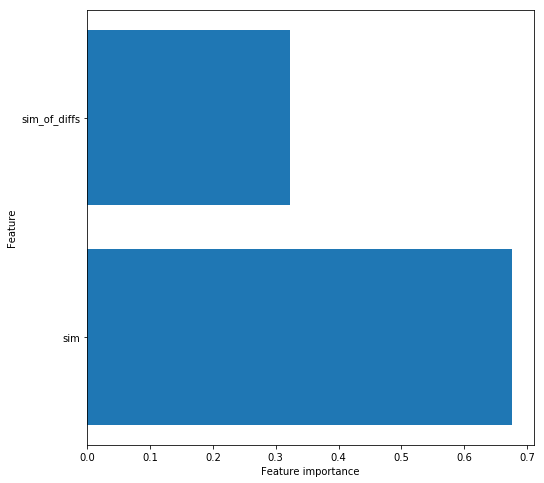

In [402]:
plot_feature_importances(rf_clf,X_npos_train)


In [403]:
rf_clfnpos = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
rf_clfnpos.fit(X_npos_train,yn_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clfnpos, X_no_pos, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 66.64%


In [395]:
rf_clfopos = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
rf_clfopos.fit(X_opos_train,yo_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clfopos, X_only_pos, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 72.89%


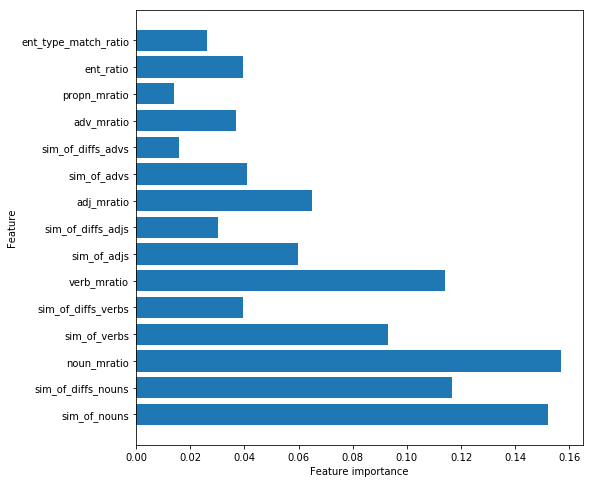

In [397]:
plot_feature_importances(rf_clfopos,X_opos_train)


In [409]:
rf_clf = RandomForestClassifier(criterion= 'gini',max_features=2, max_depth= None, min_samples_leaf= 5, min_samples_split= 20, n_estimators= 100)
rf_clf.fit(X_train,y_train)
mean_rf_cv_score = np.mean(cross_val_score(rf_clf, X, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))


Mean Cross Validation Score for Random Forest Classifier: 74.07%


In [113]:
rf_param_grid = {
    'n_estimators': [50,100],
    'criterion': ['gini'],
    'max_depth': [None],
    'min_samples_split': [20,50],
    'min_samples_leaf': [1, 2, 5],
    'max_features': [None,2,5]
}

start = time.time()
rf_grid_search = GridSearchCV(rf_clf, rf_param_grid, cv=3)
rf_grid_search.fit(X, y)

print("Testing Accuracy: {:.4}%".format(rf_grid_search.best_score_ * 100))
print("Total Runtime for Grid Search on Random Forest Classifier: {:.4} seconds".format(time.time() - start))
print("")
print("Optimal Parameters: {}".format(rf_grid_search.best_params_))


KeyboardInterrupt: 

In [400]:
from sklearn.ensemble import AdaBoostClassifier
adaclf = AdaBoostClassifier(n_estimators=100)
adaclf.fit(X_train,y_train)
mean_rf_cv_score = np.mean(cross_val_score(adaclf, X, y, cv=3))
print("Mean Cross Validation Score for Random Forest Classifier: {:.4}%".format(mean_rf_cv_score * 100))

Mean Cross Validation Score for Random Forest Classifier: 70.98%


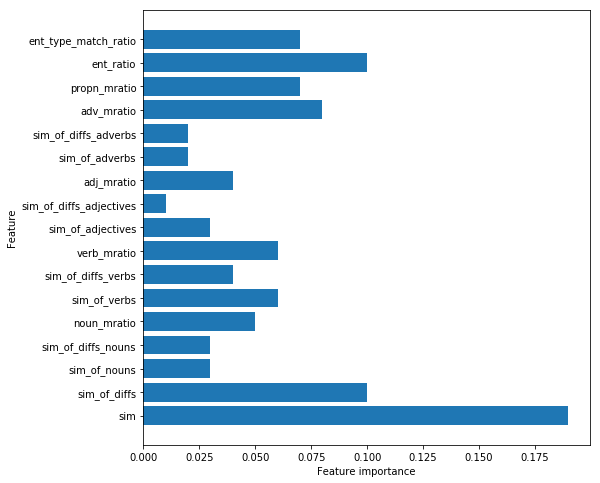

In [36]:
plot_feature_importances(adaclf_fit)

In [410]:
# Your code here
from sklearn.metrics import roc_curve, auc

#for various decision boundaries given the case member probabilites

#First calculate the probability scores of each of the datapoints:
y_score = rf_clf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

y_train_score = rf_clf.predict(X_train)
train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)


AUC: 0.7449465025162767


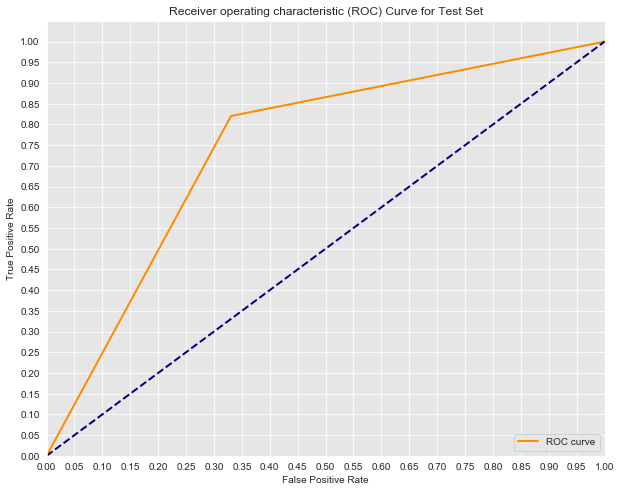

In [411]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()

In [52]:

y_score = adaclf.predict(X_test)

fpr, tpr, thresholds = roc_curve(y_test, y_score)

y_train_score = adaclf.predict(X_train)

train_fpr, train_tpr, thresholds = roc_curve(y_test, y_score)

AUC: 0.7093743974242038


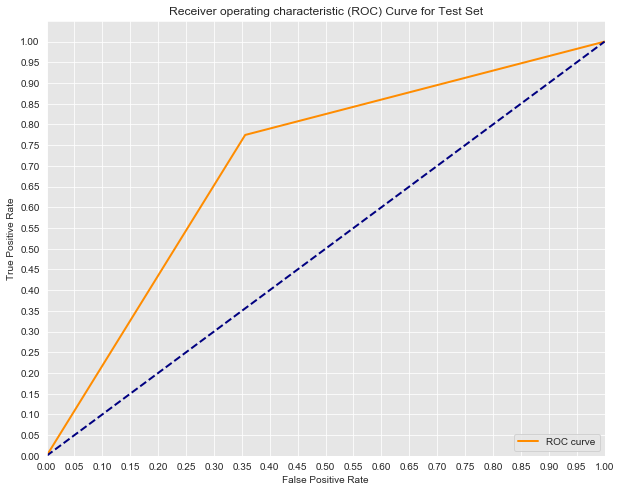

In [53]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve for Test Set')
plt.legend(loc="lower right")
print('AUC: {}'.format(auc(fpr, tpr)))
plt.show()